In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
...

---

### Load the data in
The test data is not used

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

### Some custom definitions
* metrics
* loss functions
* choice of learning parameters and settings

In [41]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = class_weights * class_entropy
    return -K.mean(weighted_entropy)/4000  # arbitrary coefficient to make it close to [0-1] interval

In [47]:
# some other global learning settings

batch_size = 3000
#patience = 4
optimizer = 'adam' # 'rmsprop'
my_metrics = [macroPrec, macroF1, macroRecall, my_crossE, "categorical_accuracy"]

In [48]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(12, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 2, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 2, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
#     plt.subplot(1, 3, 3)
#     lr = history.history['lr'] # learning rate
#     plt.plot(x, lr, 'k', label='Learning rate')
#     plt.title('Learning rate')  
#     plt.legend()
    

# choose callback functions to be given in model.fit(...)
def callbacks(LRfactor=0.5):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
            EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
           ]

---

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [53]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=None, class_weight=class_weights, epochs=10,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            self.embedd_weights = pickle.load(open(embedd, "rb"))
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"embedd_weights_{name}.p")
        pickle.dump(self.model.layers[0].get_weights(), open(file, "wb"))
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_for_embedd_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_embedd_{name}.p")
        pickle.dump(self.history, open(file, "wb"))
 


---

## Training a keras-layer embedding
### (naively, not CBOW or skipgram)
* using only global-average-pooling before softmax
* training for a fixed, short number of epochs: the goal is not to train the dense classification layer but to pretrain the embedding
* mask zeros in input
* use class_weights with default keras loss functions
* do not use class_weights with fuzzy_macroF1 or my_crossE
* save weights to files
* see which loss function got the best val_macroF1 at the last epoch

In [25]:
# dimension of the embedding space = output_dim

layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model1 = BlackBox(layers=layers1, loss='categorical_crossentropy', class_weight=class_weights, metrics=my_metrics)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_4 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 165s 329us/step - loss: 1.2475 - macroPrec: 0.0769 - macroF1: 0.0634 - macroRecall: 0.0661 - my_crossE: 1.4776 - val_loss: 0.8456 - val_macroPrec: 0.2997 - val_macroF1: 0.1506 - val_macroRecall: 0.1659 - val_my_crossE: 1.5209
Epoch 2/10
500000/500000 [==============================] - 173s 345us/step - loss: 0.6427 - macroPrec: 0.4117 - macroF1: 0.2763 - macroRecall: 0.2542 - my_crossE: 1.4935 - val_loss: 0.4797 - val_macroPrec: 0.4649 - val_macroF1: 0.3980 - val_macroRecall: 0.3601 - val_my_crossE: 1.4664
Epoch 3/10
500000/500000 [==============================] - 172s 344us/step - loss: 0.4043 - macroPrec: 0.4561 - macroF1: 0.4257 - macroRecall: 0.4029 - my_crossE: 1.4460 - val_loss: 0.3539 - val_macroPrec: 0.4513 - val_macroF1: 0.4373 - val_macroRecall: 0.4247 - val_my_crossE: 1.4288
Epoch 4/10
500000/500000 [==============================] - 167s 333us/step - loss: 0.3243

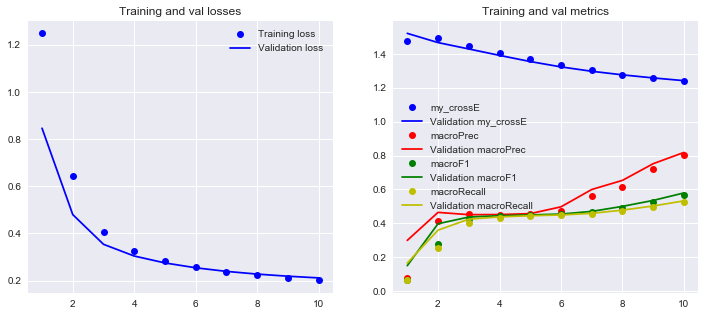

In [27]:
model1.plot()

For all measurements the results on test and validation data were very close.
At first the macro precision, recall and F1 (per batch) rose together and platoed around 0.4 for about three epochs. Then the precision picked up visibly but the recall was much slower to pick up, and consequently the final F1 after 10 epoch had reached a meager 0.58%.

In [28]:
name = "50dim_GlblAvg_CatCrossE_10epochs"
model1.save_embedd(name)
#model1.Ksave(name)
#model1.save(name)

---

In [35]:
layers2 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model2 = BlackBox(layers=layers2, loss=fuzzy_macroF1_flip, class_weight=None, metrics=my_metrics)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_7 ( (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [36]:
model2.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 176s 351us/step - loss: 0.8381 - macroPrec: 0.0978 - macroF1: 0.0514 - macroRecall: 0.0459 - my_crossE: 1.4616 - val_loss: 0.7616 - val_macroPrec: 0.3272 - val_macroF1: 0.2290 - val_macroRecall: 0.2023 - val_my_crossE: 1.4922
Epoch 2/10
500000/500000 [==============================] - 168s 335us/step - loss: 0.6667 - macroPrec: 0.4495 - macroF1: 0.3776 - macroRecall: 0.3502 - my_crossE: 1.4626 - val_loss: 0.5969 - val_macroPrec: 0.4430 - val_macroF1: 0.4313 - val_macroRecall: 0.4204 - val_my_crossE: 1.4165
Epoch 3/10
500000/500000 [==============================] - 172s 344us/step - loss: 0.5551 - macroPrec: 0.4587 - macroF1: 0.4379 - macroRecall: 0.4301 - my_crossE: 1.3448 - val_loss: 0.5124 - val_macroPrec: 0.5847 - val_macroF1: 0.4522 - val_macroRecall: 0.4415 - val_my_crossE: 1.2858
Epoch 4/10
500000/500000 [==============================] - 173s 345us/step - loss: 0.4531

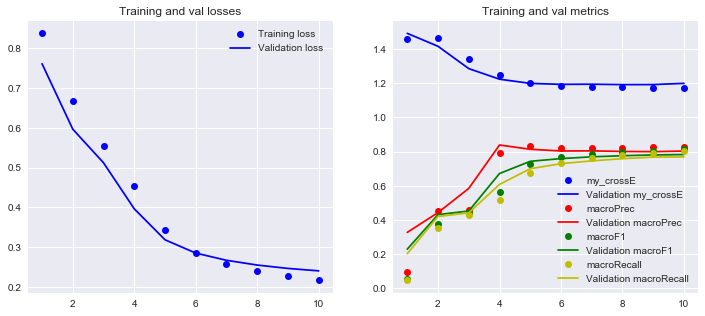

In [37]:
model2.plot()

Again the validation data followed the test data during the 10 epochs. This time there is no notable platoe of the three metrics, precision/recall/F1, around 0.4. They comfortably rise together up to about 0.78 and stay there at practically the same value. Interestingly our other custom metric, the weighted categorical crossentropy (*my_crossE*) was warning us about overfitting starting already from 7th epoch.

In [38]:
name = "50dim_GlblAvg_F1flip_10epochs"
model2.save_embedd(name)
# model2.Ksave(name)
# model2.save(name)

---

In [50]:
# dimension of the embedding space, output_dim
# custom loss_2

layers3 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model3 = BlackBox(layers=layers3, loss=my_crossE, class_weight=None, metrics=my_metrics)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_10  (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [51]:
model3.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/10
500000/500000 [==============================] - 165s 330us/step - loss: 1.1665 - macroPrec: 0.0206 - macroF1: 4.3428e-04 - macroRecall: 2.2119e-04 - my_crossE: 1.1665 - categorical_accuracy: 0.8096 - val_loss: 1.1445 - val_macroPrec: 0.2223 - val_macroF1: 0.0095 - val_macroRecall: 0.0049 - val_my_crossE: 1.1445 - val_categorical_accuracy: 0.8544
Epoch 2/10
500000/500000 [==============================] - 164s 328us/step - loss: 1.1169 - macroPrec: 0.5520 - macroF1: 0.1903 - macroRecall: 0.1352 - my_crossE: 1.1169 - categorical_accuracy: 0.8580 - val_loss: 1.0920 - val_macroPrec: 0.8856 - val_macroF1: 0.4327 - val_macroRecall: 0.3249 - val_my_crossE: 1.0920 - val_categorical_accuracy: 0.8609
Epoch 3/10
500000/500000 [==============================] - 165s 329us/step - loss: 1.0757 - macroPrec: 0.8264 - macroF1: 0.6111 - macroRecall: 0.5171 - my_crossE: 1.0757 - categorical_accuracy: 0.8651 - val_loss: 1.0645 - val_macroPrec

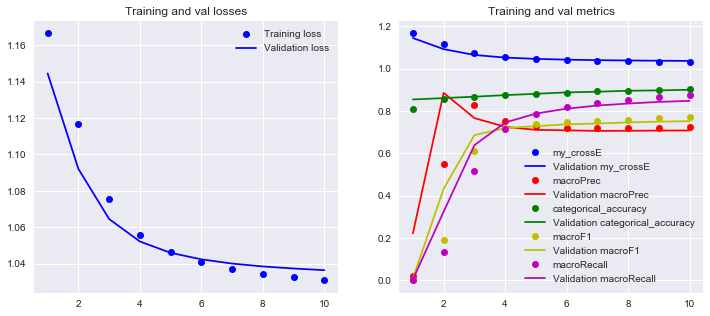

In [54]:
model3.plot()

In [52]:
name = "50dim_GlblAvg_MyCrossE_5epochs"
model3.save_embedd(name)
model3.Ksave(name)
model3.save_hist(name)

TypeError: can't pickle _thread.RLock objects

---